In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import time
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split
from pathlib import Path
from model import Model

In [2]:
VERSION = 'v9'
BATCH_SIZE = 32
EPOCHS = 300
TRAIN_TEST_SPLIT = 0.8
DATASET_PATH = f'dataset_{VERSION}'
EXPORT_PATH = Path(f"model_{VERSION}")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EVAL = "loss" # loss or acc

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor()
])

In [4]:
dataset = ImageFolder(root=DATASET_PATH, transform=train_transform)

n_test = int((1-TRAIN_TEST_SPLIT) * len(dataset))
train_set, test_set = random_split(dataset, [n_test, len(dataset) - n_test])

train_data_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_data_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

len(train_data_loader), len(test_data_loader)

train_data_size=1625, test_data_size=287


In [ ]:
# compute mean and std for normalization
data = torch.stack([d for d,_ in dataset])
means = data.mean(dim=(0, 2, 3))
stds = data.std(dim=(0, 2, 3))

means, stds

In [5]:
def export(model, stats):
    EXPORT_PATH.mkdir(parents=True, exist_ok=True)

    # pytorch jit
    torch.jit.save(torch.jit.script(model), EXPORT_PATH / f"model_{VERSION}.pt")

    # onnx
    torch.onnx.export(model.cpu(),                                # model being run
                    torch.randn(1, 3, 224, 224).to('cpu'),    # model input (or a tuple for multiple inputs)
                    EXPORT_PATH / f"model_{VERSION}.onnx",           # where to save the model (can be a file or file-like object)
                    input_names = ['input'],              # the model's input names
                    output_names = ['output'],
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}}) 

    # save stats
    with open(EXPORT_PATH / f"stats_{VERSION}.txt", "w") as f:
        f.write(stats)
    
    model.to(DEVICE)

In [6]:
model = Model(means, stds)
model = model.to(DEVICE)

In [7]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Epoch: 000 | Train: 0.5501 (78.7692%) | Test: 0.3983 (92.3345%) | Time: 40.3714s
Epoch: 001 | Train: 0.2941 (90.0923%) | Test: 0.1765 (95.1220%) | Time: 34.7457s
Epoch: 002 | Train: 0.2315 (91.4462%) | Test: 0.1523 (94.7735%) | Time: 33.1600s
Epoch: 003 | Train: 0.2149 (92.8615%) | Test: 0.1755 (93.3798%) | Time: 33.1006s
Epoch: 004 | Train: 0.1963 (92.9846%) | Test: 0.1477 (94.7735%) | Time: 33.7263s
Epoch: 005 | Train: 0.1908 (92.9231%) | Test: 0.1216 (95.8188%) | Time: 32.9395s
Epoch: 006 | Train: 0.1712 (93.9077%) | Test: 0.1400 (94.4251%) | Time: 33.1758s
Epoch: 007 | Train: 0.1747 (93.9077%) | Test: 0.1544 (95.4704%) | Time: 33.0694s
Epoch: 008 | Train: 0.1623 (94.4615%) | Test: 0.1348 (94.4251%) | Time: 33.1249s
Epoch: 009 | Train: 0.1539 (93.9077%) | Test: 0.1861 (93.3798%) | Time: 33.2059s
Epoch: 010 | Train: 0.1496 (94.9538%) | Test: 0.1603 (95.4704%) | Time: 33.0429s
Epoch: 011 | Train: 0.1567 (93.9077%) | Test: 0.1325 (96.5157%) | Time: 32.8955s
Epoch: 012 | Train: 0.1378 (

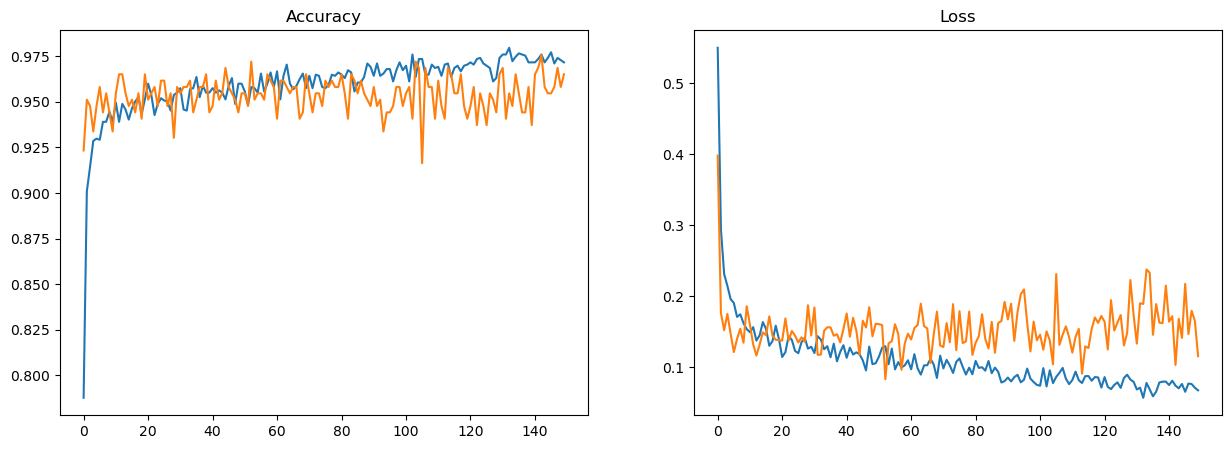

In [10]:
# Training
history = []
saved_epochs = []

best_train_acc = 0.95
best_test_acc = 0.95
best_train_loss = 0.2
best_test_loss = 0.2

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # Set to training mode
    model.train()
    
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    test_acc = 0.0
    
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = loss_function(outputs, labels)

        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
        #print(f"Training batch number: {i:03d}| Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

    # Test - No gradient tracking needed
    with torch.no_grad():
    
        # Set to evaluation mode
        model.eval()
    
        for j, (inputs, labels) in enumerate((test_data_loader)):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels)

            # Compute the total loss for the batch and add it to test_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate test accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
                
            # Compute total accuracy in the whole batch and add to test_acc
            test_acc += acc.item() * inputs.size(0)
            #print(f"Test Batch number: {j:03d}| Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_set) 
        avg_train_acc = train_acc/float(len(train_set) )
        
        # Find average test loss and test accuracy
        avg_test_loss = test_loss/len(test_set) 
        avg_test_acc = test_acc/float(len(test_set) )
        
        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
        epoch_end = time.time()
        
        better = False
        if EVAL == "loss":
            if avg_train_loss < best_train_loss and avg_test_loss < best_test_loss:
                better = True
        elif EVAL == "acc":
            if avg_train_acc >= best_train_acc and avg_test_acc >= best_test_acc:
                better = True

        saved = ""
        if better:
            best_train_acc = avg_train_acc
            best_test_acc = avg_test_acc
            best_train_loss = avg_train_loss
            best_test_loss = avg_test_loss

            saved_epochs.append(epoch)

            stats = f"Epoch: {epoch} | Train: {avg_train_loss:.4f} ({avg_train_acc*100:.4f}%) | Test: {avg_test_loss:.4f} ({avg_test_acc*100:.4f}%)"
            export(model, stats)
            saved = "📍 "
        
        print(f"{saved}Epoch: {epoch:03d} | Train: {avg_train_loss:.4f} ({avg_train_acc*100:.4f}%) | Test: {avg_test_loss:.4f} ({avg_test_acc*100:.4f}%) | Time: {epoch_end-epoch_start:.4f}s")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot([h[2] for h in history], label='train acc')
axs[0].plot([h[3] for h in history], label='valid acc')
axs[0].plot(saved_epochs, [h[2] for i, h in enumerate(history) if i in saved_epochs], 'ro', label='saved model')
axs[0].plot(saved_epochs, [h[3] for i, h in enumerate(history) if i in saved_epochs], 'ro')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot([h[0] for h in history], label='train loss')
axs[1].plot([h[1] for h in history], label='valid loss')
axs[1].plot(saved_epochs, [h[0] for i, h in enumerate(history) if i in saved_epochs], 'ro', label='saved model')
axs[1].plot(saved_epochs, [h[1] for i, h in enumerate(history) if i in saved_epochs], 'ro')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

plt.show()

In [11]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

def inference(model, filename):
    inference_time = time.time()
    image = Image.open(filename)

    plt.imshow(image)
    image_tensor = test_transform(image)
    image_tensor = image_tensor.view(1, 3, 224, 224)
    image_tensor = image_tensor.to(DEVICE)

    with torch.no_grad():
        model.eval()

        out = model(image_tensor)
        ps = torch.exp(out)
        
        return ps.cpu()[0], time.time() - inference_time